In [1]:
import sys
import csv
import os
sys.path.insert(0, '..')
sys.path.insert(0, '../..')
import ecoscape_connectivity
from scgt import GeoTiff, Tile
import time
import torch
import matplotlib.pyplot as plt
import random
import string

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = (torch.device('cuda') if torch.cuda.is_available() else 
          torch.device('mps') if torch.backends.mps.is_available() else
          torch.device('cpu'))


In [4]:
DATA_PATH="assets"

HABITAT_PATH = os.path.join(DATA_PATH, "habitat_CA.tif")
LANDCOVER_PATH = os.path.join(DATA_PATH, "terrain_CA.tif")
PERMEABILITY_PATH = os.path.join(DATA_PATH, "permeability_CA.csv")


In [5]:
permeability_dict = ecoscape_connectivity.read_transmission_csv(PERMEABILITY_PATH)

CONNECTIVITY_PATH = os.path.join(DATA_PATH, "Outputs/connectivity_CA.tif")
FLOW_PATH = os.path.join(DATA_PATH, "Outputs/flow_CA.tif")


## Experiment

In [6]:
titles = {
    "compute_connectivity_diagonal": "Diagonal penalization",
    "compute_connectivity_orig": "Original",
    "compute_connectivity_v4": "Infinite flips",
    "compute_connectivity_v5": "Infinite flips w termination",
    "compute_connectivity_v6": "Infinite flips w first-traversal",
    "RandomPropagate_v5": "Infinite flips w termination",
    "RandomPropagate_v6": "Infinite flips w first-traversal",
    "compute_connectivity_v3": "Two coin flips",
    "compute_connectivity_v2": "Single coin flip",
}

## Infinite flips w first-traversal rolnx

Time: 62.68178415298462
(1, 289, 333)


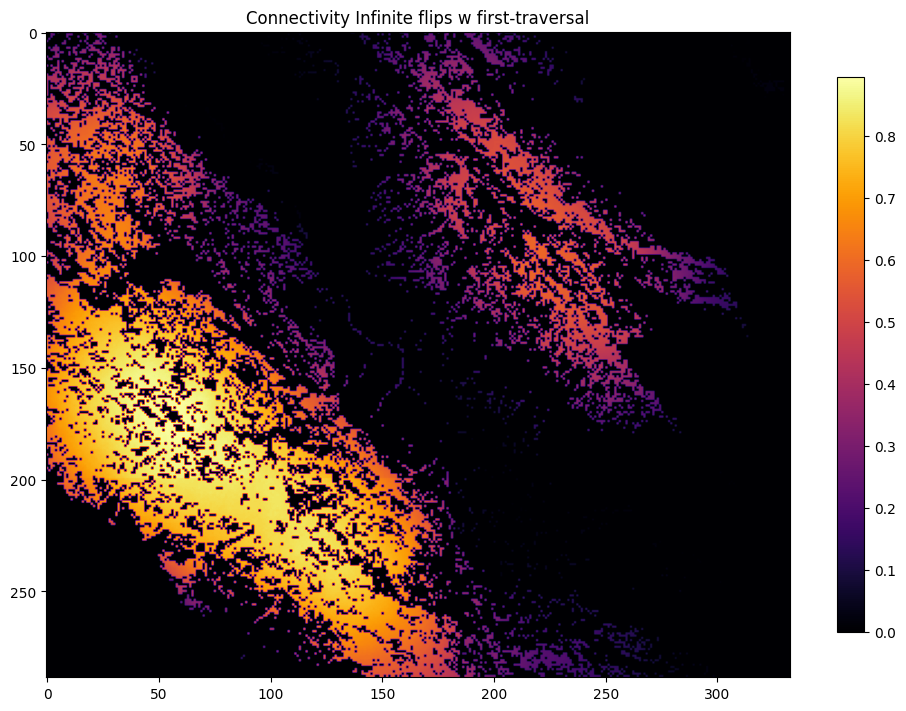

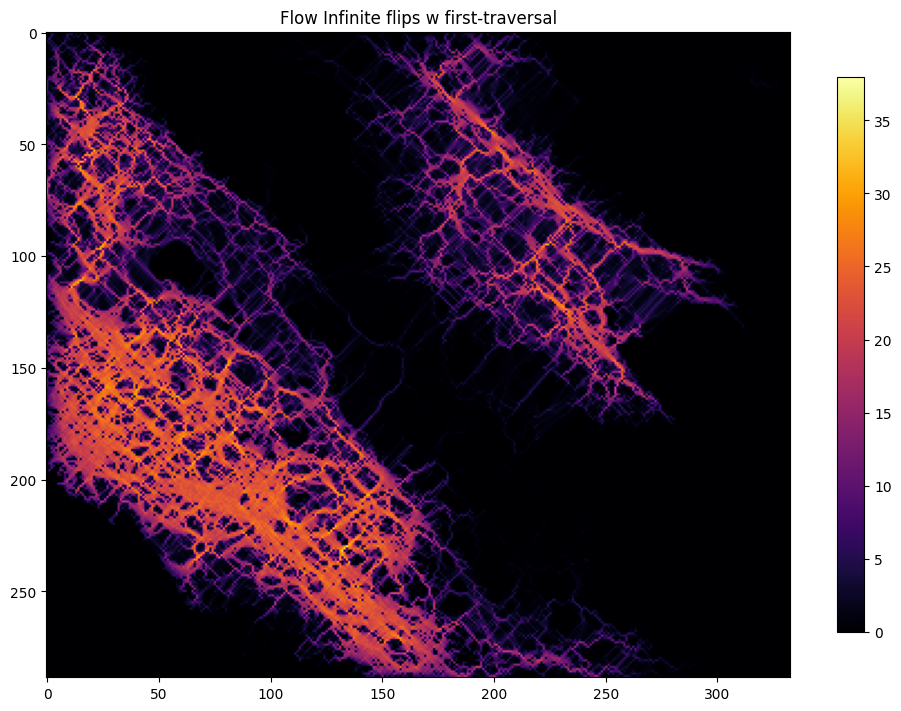

In [7]:
from IPython.display import display, Markdown
algos = [
    "compute_connectivity_v6", 
    ]

experiment = "".join(random.sample(string.ascii_lowercase, 5))
for algo in algos:
    display(Markdown(f"## {titles[algo]} {experiment}"))
    t0 = time.time()
    alg = getattr(ecoscape_connectivity, algo)
    alg(
        habitat_fn=HABITAT_PATH,
        landcover_fn=LANDCOVER_PATH,
        permeability_dict=permeability_dict,
        connectivity_fn=CONNECTIVITY_PATH,
        flow_fn=FLOW_PATH,
        tile_size=200,
        border_size=50,
        padding_size=50,
        batch_size=20,
        num_simulations=1000,
        dispersal=50,
    )
    print("Time:", time.time() - t0)
    single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title=f"Connectivity {titles[algo]}")
    single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title=f"Flow {titles[algo]}")

## Longer dispersal

## Infinite flips w first-traversal ncrfb

Time: 49.721068143844604
(1, 189, 233)


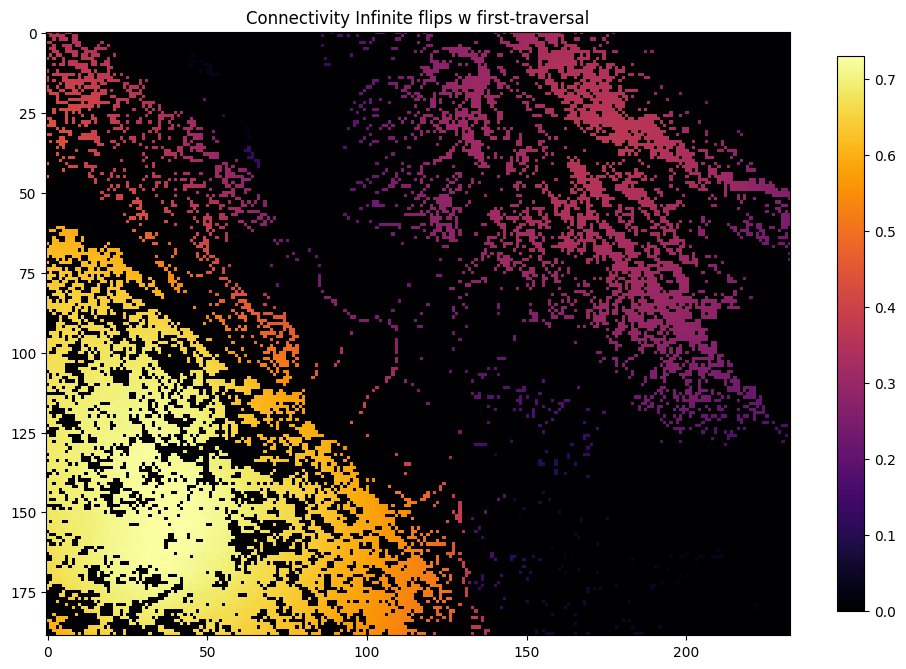

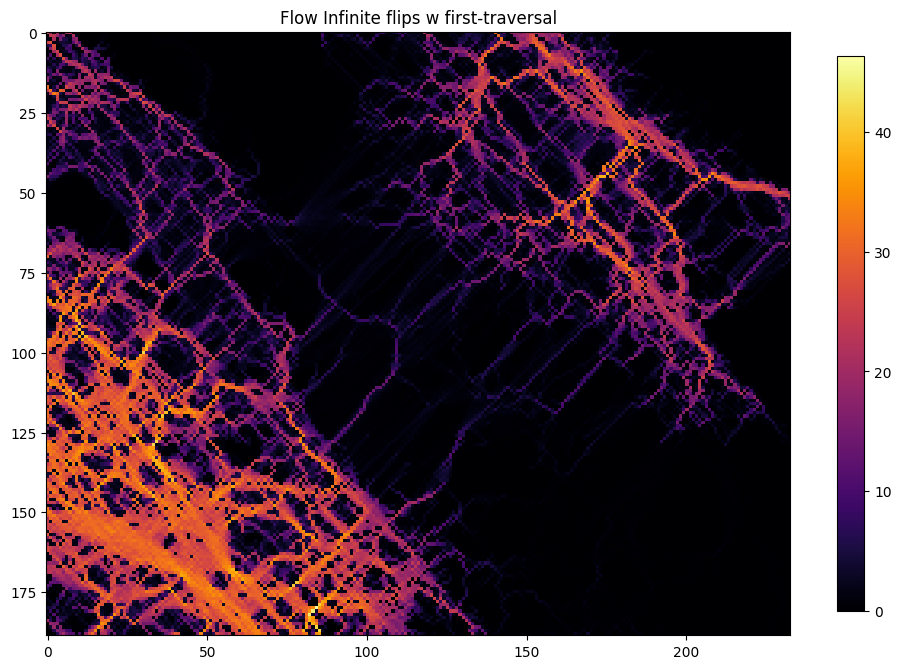

In [8]:
from IPython.display import display, Markdown
algos = [
    "compute_connectivity_v6",
    ]


experiment = "".join(random.sample(string.ascii_lowercase, 5))
for algo in algos:
    display(Markdown(f"## {titles[algo]} {experiment}"))
    t0 = time.time()
    alg = getattr(ecoscape_connectivity, algo)
    alg(
        habitat_fn=HABITAT_PATH,
        landcover_fn=LANDCOVER_PATH,
        permeability_dict=permeability_dict,
        connectivity_fn=CONNECTIVITY_PATH,
        flow_fn=FLOW_PATH,
        tile_size=1000,
        border_size=50,
        batch_size=20,
        gap_crossing=0,
        num_simulations=1000,
        dispersal=100,
    )
    print("Time:", time.time() - t0)
    single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title=f"Connectivity {titles[algo]}")
    single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title=f"Flow {titles[algo]}")

## Scaled permeability

## Infinite flips w termination epsyr

Time: 67.12802505493164
(1, 189, 233)


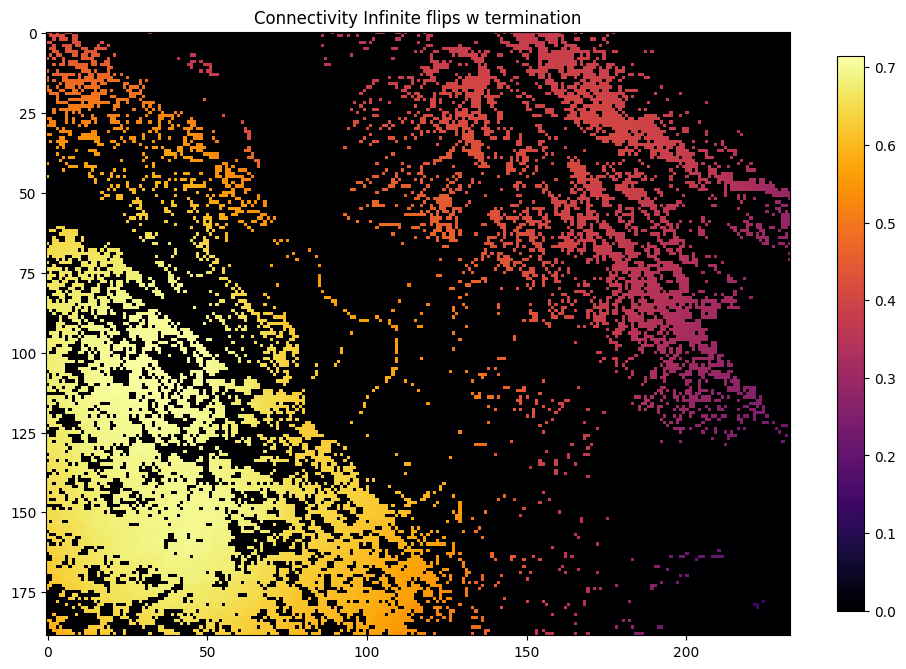

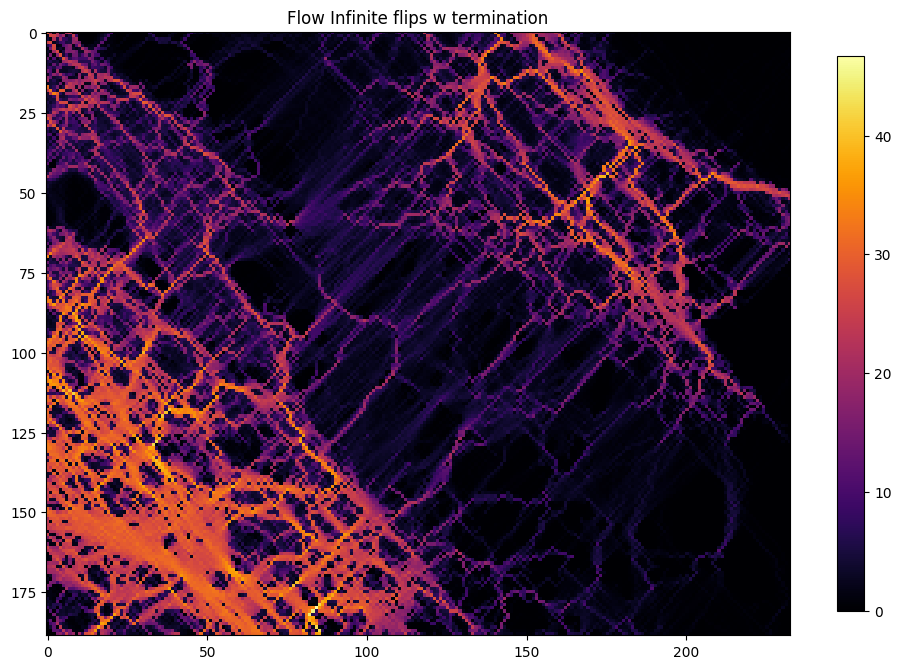

## Infinite flips w first-traversal epsyr

Time: 71.45586109161377
(1, 189, 233)


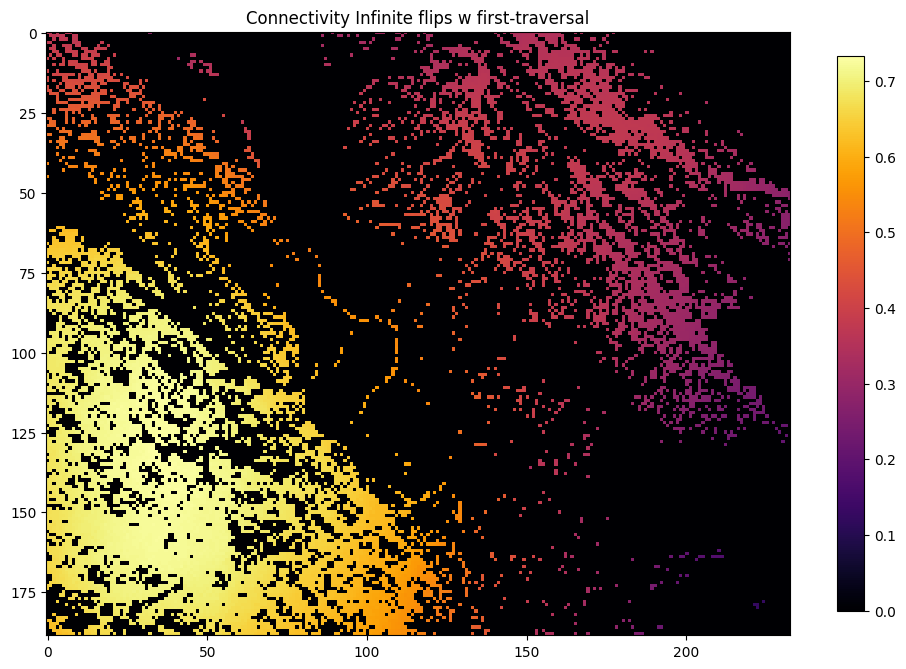

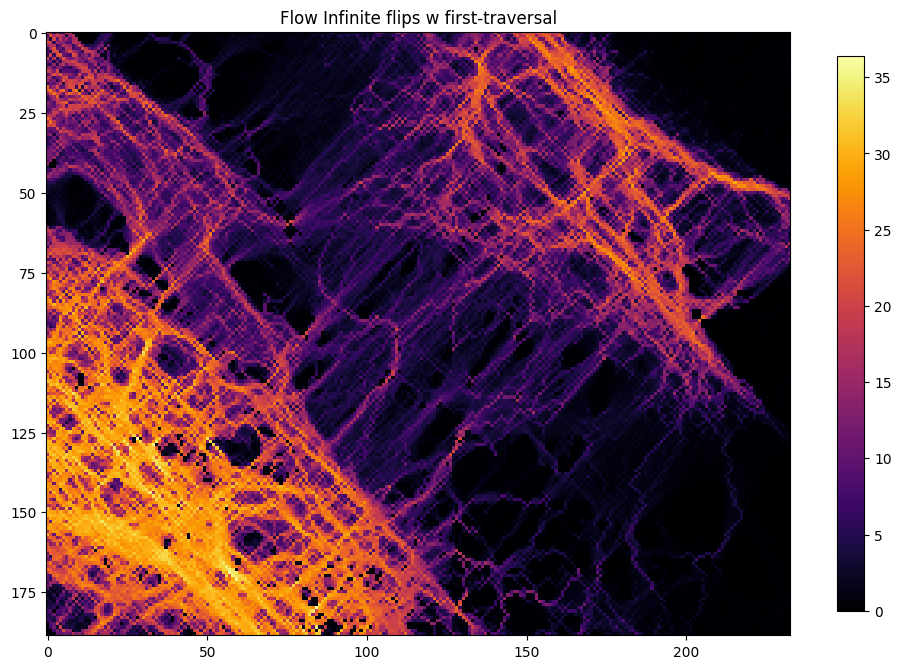

In [9]:
from IPython.display import display, Markdown
algos = [
    "compute_connectivity_v6",
    ]

experiment = "".join(random.sample(string.ascii_lowercase, 5))
for algo in algos:
    display(Markdown(f"## {titles[algo]} {experiment}"))
    t0 = time.time()
    alg = getattr(ecoscape_connectivity, algo)
    alg(
        habitat_fn=HABITAT_PATH,
        landcover_fn=LANDCOVER_PATH,
        permeability_dict=permeability_dict,
        permeability_scaling=1/12,
        connectivity_fn=CONNECTIVITY_PATH,
        flow_fn=FLOW_PATH,
        border_size=100,
        padding_size=100,
        tile_size=1000,
        batch_size=20,
        gap_crossing=0,
        num_simulations=1000,
        include_border=False,
        dispersal=100,
    )
    print("Time:", time.time() - t0)
    single_connectivity = GeoTiff.from_file(CONNECTIVITY_PATH)
    t = single_connectivity.get_all_as_tile(b=0)
    print(t.m.shape)
    t.draw_tile(width=12, height=12, title=f"Connectivity {titles[algo]}")
    single_flow = GeoTiff.from_file(FLOW_PATH)
    t = single_flow.get_all_as_tile(b=0)
    t.draw_tile(width=12, height=12, title=f"Flow {titles[algo]}")

## Ball

### Infinite flips w termination xgvek

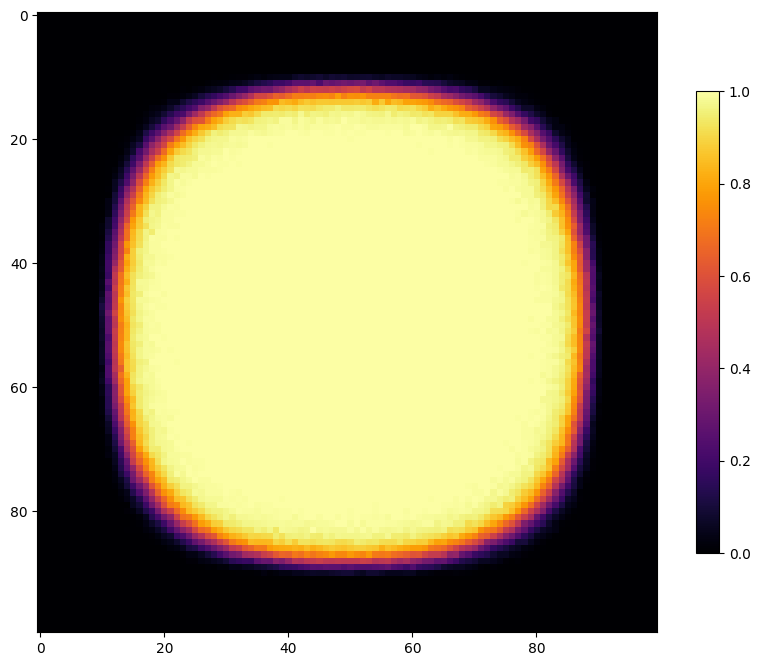

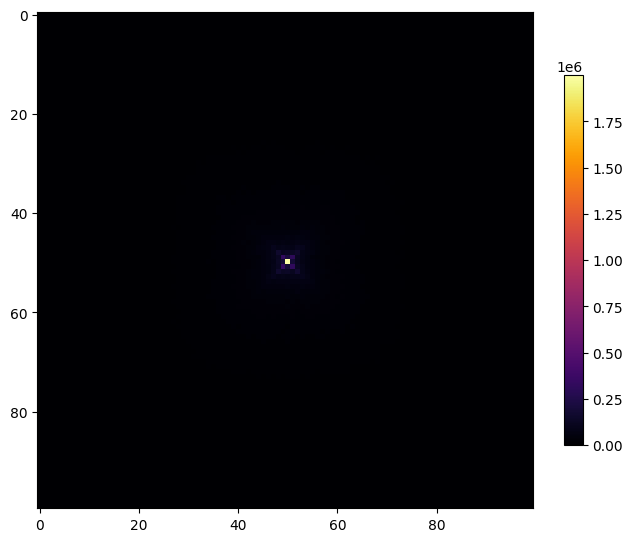

### Infinite flips w first-traversal xgvek

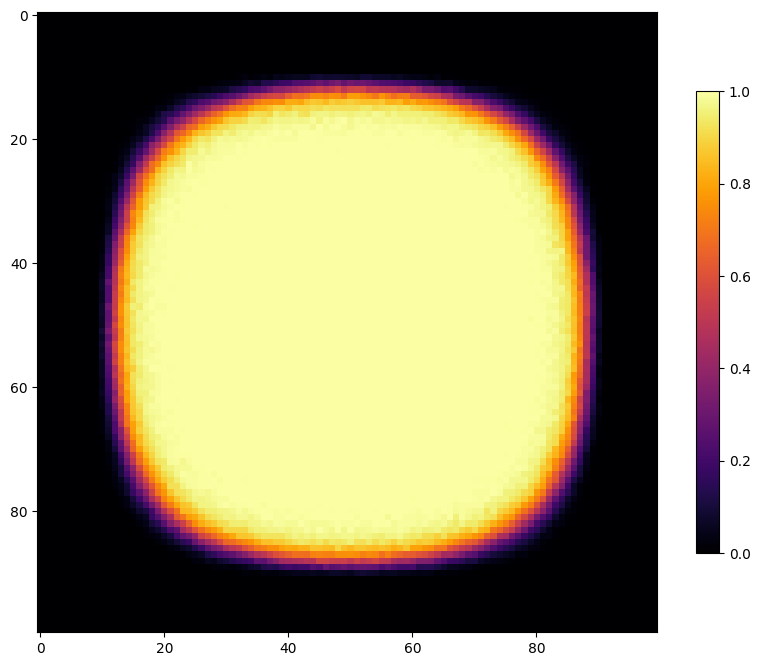

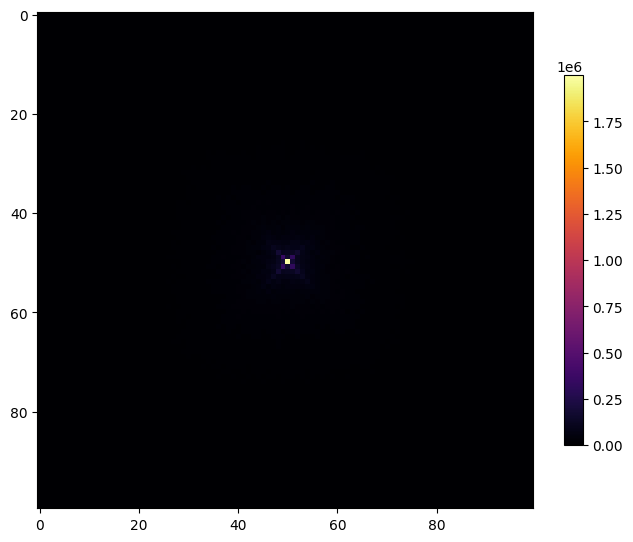

In [12]:
algos = [
    "RandomPropagate_v5",
    "RandomPropagate_v6",
    ]

experiment = "".join(random.sample(string.ascii_lowercase, 5))
for algo in algos: 
    alg = getattr(ecoscape_connectivity, algo)
    display(Markdown(f"### {titles[algo]} {experiment}"))
    hab = torch.ones((100, 100), device=device)
    ter = hab # torch.zeros((100, 100), device=device)
    repopulator = alg(
        hab, ter, 
        num_spreads=40, 
        spread_size=1, device=device).to(device)
    seeds = torch.zeros((400, 100, 100))
    seeds[:, 50, 50] = 1
    seeds = seeds.to(device)
    pop = repopulator(seeds)
    a = pop.cpu().detach().numpy()
    a = np.mean(a, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(a, cmap='inferno')
    plt.colorbar(shrink=0.6)
    plt.show()
    tot_pop = pop.sum()
    tot_pop.backward()
    flow = repopulator.get_grad()
    flow = flow.cpu().detach().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(flow, cmap='inferno')
    plt.colorbar(shrink=0.6)
    plt.show()
